In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
from scripts.licence_plate_detection import detect_license_plate
from scripts.image_preprocessing import deskew
from scripts.feature_extraction import extract_hog_features

In [6]:
import pickle
model = pickle.load(open("models/hog_svm.pkl", "rb"))

def character_prediction(char_image):
    char_image = cv2.resize(char_image, (28, 28))
    char_image = deskew(char_image, (28, 28))
    prediction = model.predict([char_image])
    return prediction[0]

In [7]:
license_plates = []
for image_file in os.listdir("dataset/sampleplates"):
    image_path = os.path.join("dataset/sampleplates", image_file)
    image = cv2.imread(image_path)
    
    image = cv2.resize(image, (640, 640))
    license_plate = detect_license_plate(image)
    if license_plate:
        for contour in license_plate:
            x, y, w, h = cv2.boundingRect(contour)
            license_plates.append(image[y:y+h, x:x+w])

In [8]:
def segment_characters(image):
    plate_image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    plate_image_blurred = cv2.GaussianBlur(plate_image_gray, (5, 5), 0)
    
    binary_image = cv2.adaptiveThreshold(plate_image_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_char_candidates = []
    plate_height, plate_width = image.shape[:2]

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        solidity = cv2.contourArea(contour) / float(w * h)
        height_ratio = h / float(plate_height)

        if 0.1 < aspect_ratio < 1.0 and 0.35 < height_ratio < 0.9 and solidity > 0.2:
            valid_char_candidates.append((x, y, w, h))

    if not valid_char_candidates:
        return image, []

    def sort_key(bounding_box):
        return bounding_box[0]

    def multi_line_sort_key(bounding_box):
        return (bounding_box[1] // (plate_height // 2), bounding_box[0])

    is_two_line = max(b[1] + b[3] for b in valid_char_candidates) - min(b[1] for b in valid_char_candidates) > plate_height * 0.7 and len(valid_char_candidates) > 5

    if is_two_line:
        sorted_chars = sorted(valid_char_candidates, key=multi_line_sort_key)
    else:
        sorted_chars = sorted(valid_char_candidates, key=sort_key)

    output_image = image.copy()
    segmented_characters = []

    for x, y, w, h in sorted_chars:
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        char_crop = plate_image_gray[y:y+h, x:x+w]
        
        char_resized = cv2.resize(char_crop, (28, 28), interpolation=cv2.INTER_AREA)
        _, char_thresh = cv2.threshold(char_resized, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        segmented_characters.append(char_thresh)
        
    return output_image, segmented_characters

ValueError: Found array with dim 3, while dim <= 2 is required by SVC.

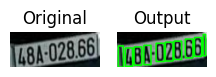

In [9]:
for index, plate in enumerate(license_plates):
    output_image, char_images = segment_characters(plate)

    len_cols = len(char_images) + 1
    row = index + 1
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len_cols, 1)
    plt.imshow(plate)
    plt.axis('off')
    plt.title('Original')

    plt.subplot(1, len_cols, 2)
    plt.imshow(output_image, cmap='gray')
    plt.axis('off')
    plt.title('Output')

    for index, char_image in enumerate(char_images):
        character = character_prediction(char_image)

        plt.subplot(1, len_cols, index + 3)
        plt.imshow(char_image, cmap='gray')
        plt.axis('off')
        plt.title(character)
    plt.show()